# Bike Sharing Demand
Forecast use of a city bikeshare system

https://www.kaggle.com/competitions/bike-sharing-demand/overview


`평가 방법 : RMSE`
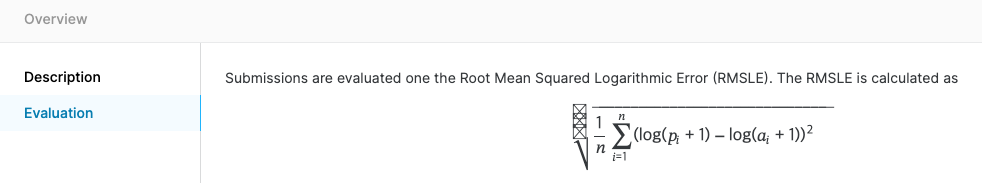

`Data Fields`
* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

분류와 회귀 중 회귀와 관련된 문제 -> 자전거 대여량을 예측하는 문제이기 때문

In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 적용
plt.style.use('ggplot')

# 한글 폰트 깨지는 문제 해결
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 폰트 깨지는 문제 해결
mpl.rcParams['axes.unicode_minus'] = False 

In [45]:
train = pd.read_csv('02_bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [3]:
# train.columns
# train.dtypes 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [8]:
# 기온에 대한 정보 확인
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [9]:
# null인 데이터들이 하나도 없다
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<AxesSubplot: >

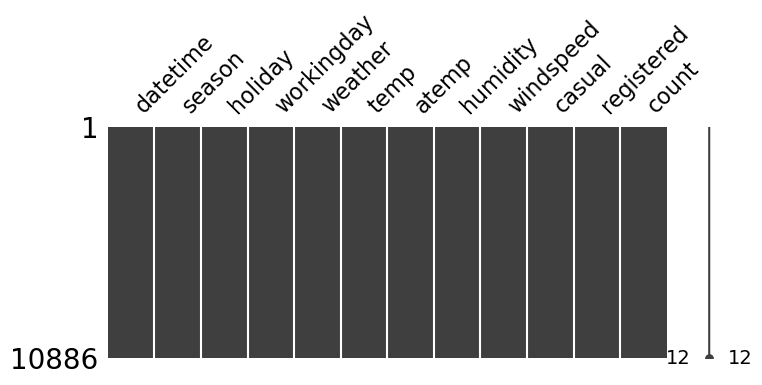

In [14]:
import missingno as msno

msno.matrix(train, figsize=(8, 3))

In [48]:
# 시각화하기 편하게 하기 위해 ["year", "month", "day", "hour", "minute", "second"] Column 추가
train["year"] = train["datetime"].dt.year 
train["month"] = train["datetime"].dt.month 
train["day"] = train["datetime"].dt.day 
train["hour"] = train["datetime"].dt.hour 
train["minute"] = train["datetime"].dt.minute 
train["second"] = train["datetime"].dt.second 
train.shape

(10886, 18)

In [44]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek,year_month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5,0 2011\n1 2011\n2 2011\n3...
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5,0 2011\n1 2011\n2 2011\n3...
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5,0 2011\n1 2011\n2 2011\n3...
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5,0 2011\n1 2011\n2 2011\n3...
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5,0 2011\n1 2011\n2 2011\n3...


[Text(0, 0.5, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

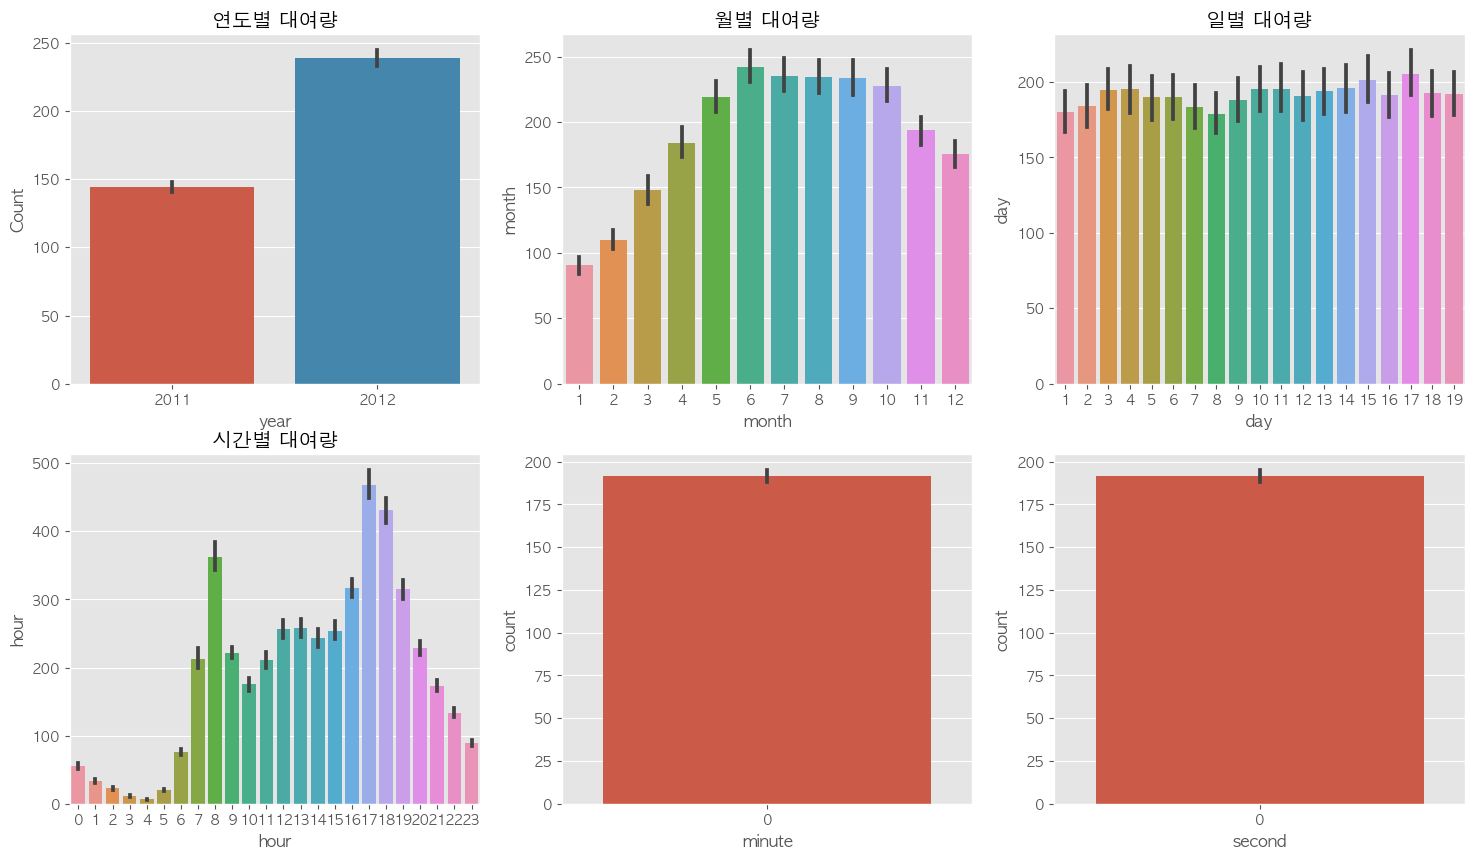

In [22]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 10)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count', title='연도별 대여량')
ax2.set(ylabel='month', title='월별 대여량')
ax3.set(ylabel='day', title='일별 대여량')
ax4.set(ylabel='hour', title='시간별 대여량')

* 연도별 대여량은 2011년보다 2012년이 더 많다.
* 월별 대여량은 6월에 가장 많고 7~10월에도 대여량이 많다. 그리고 1월에 가장 적다.
* 일별대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 feature로 사용하면 안 된다.
* 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
* 분, 초도 다 0이기 때문에 의미가 없다.

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

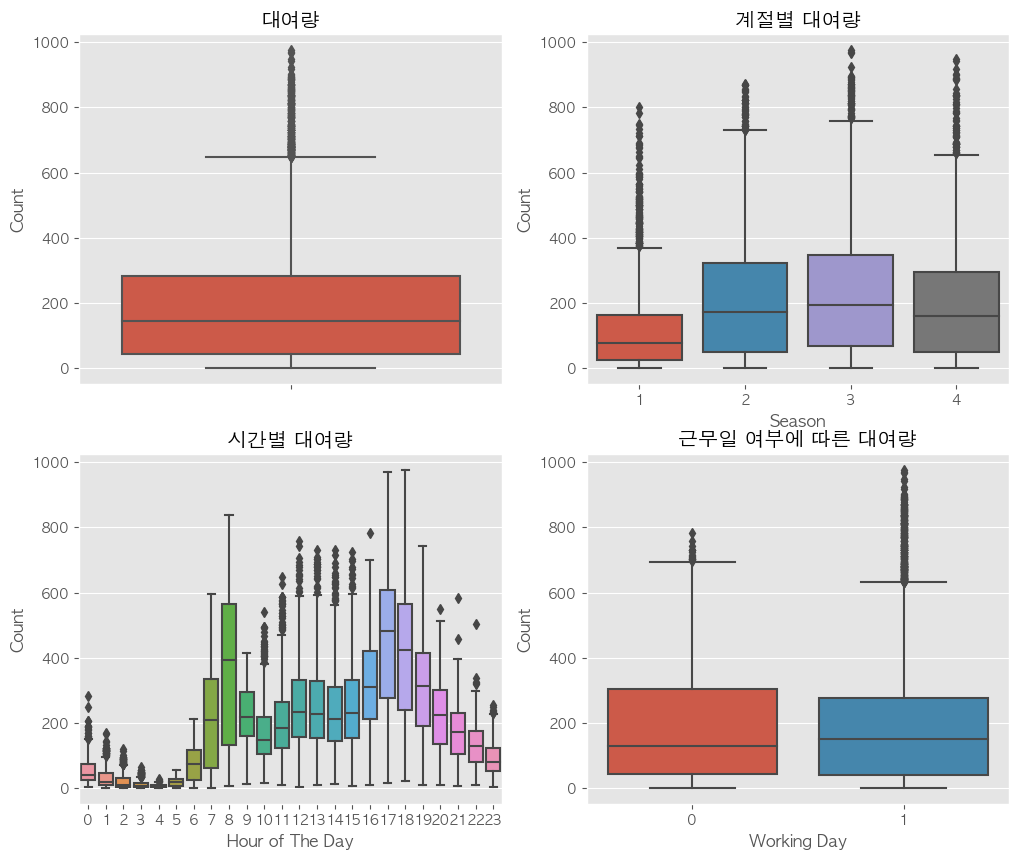

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)

sns.boxplot(data=train, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=train, y='count', x='season',  orient='v', ax=axes[0][1])
sns.boxplot(data=train, y='count', x='hour',  orient='v', ax=axes[1][0])
sns.boxplot(data=train, y='count', x='workingday',  orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count', title='대여량')
axes[0][1].set(xlabel='Season', ylabel='Count', title='계절별 대여량')
axes[1][0].set(xlabel='Hour of The Day', ylabel='Count', title='시간별 대여량')
axes[1][1].set(xlabel='Working Day', ylabel='Count', title='근무일 여부에 따른 대여량')


In [26]:
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [27]:
train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

<AxesSubplot: xlabel='hour', ylabel='count'>

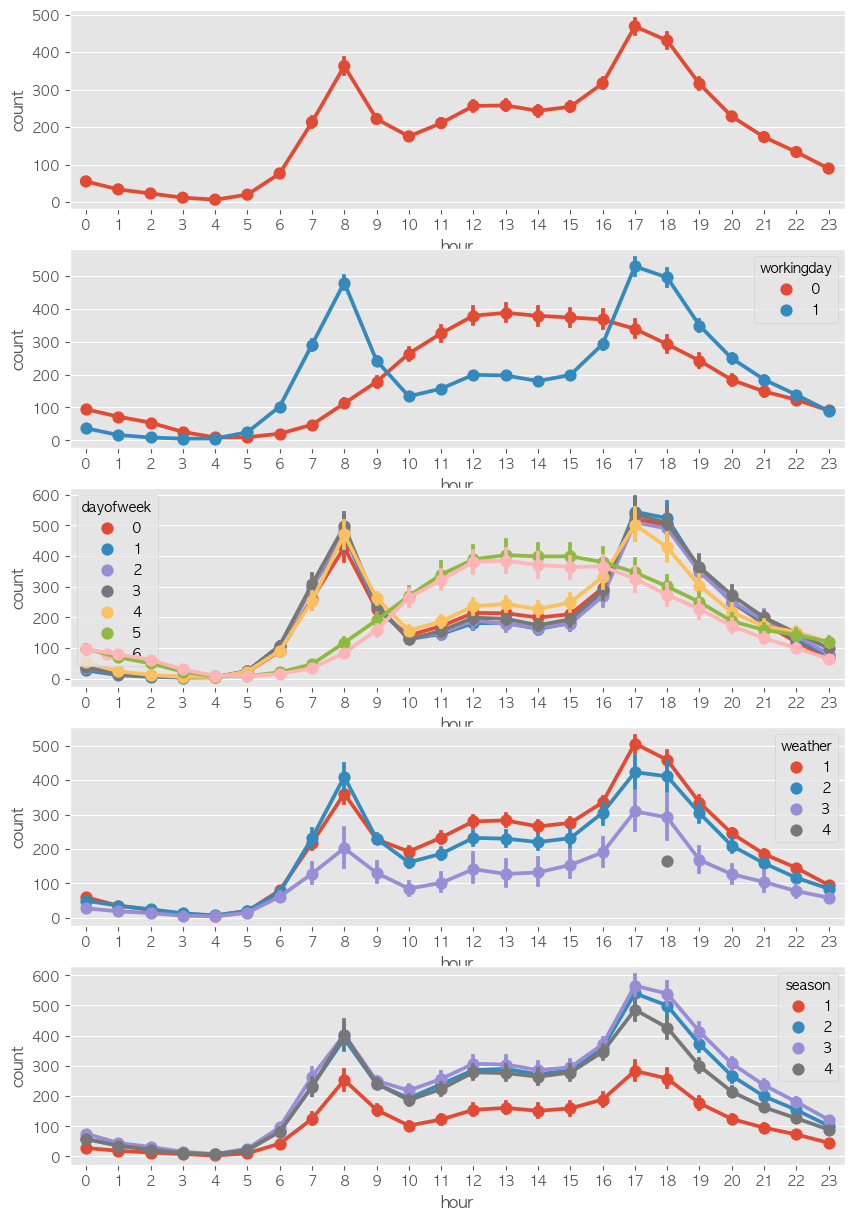

In [29]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(10,15)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

In [30]:
# 상관관계를 분석
corrMat = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMat = corrMat.corr()
print(corrMat)

mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot: >

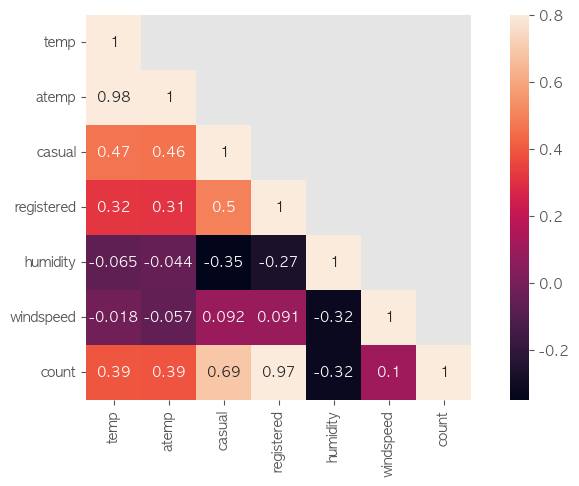

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
sns.heatmap(corrMat, mask=mask,vmax=.8, square=True,annot=True)

# 온도, 습도, 풍속은 거의 연관관계가 없다
# 대여량과 가장 연관이 높은 건 registered로 등록된 대여자가 많지만, test데이터에는 이 값이 없다
# atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다. (거의 같은 데이터로 볼 수 있기 때문)

<AxesSubplot: xlabel='humidity', ylabel='count'>

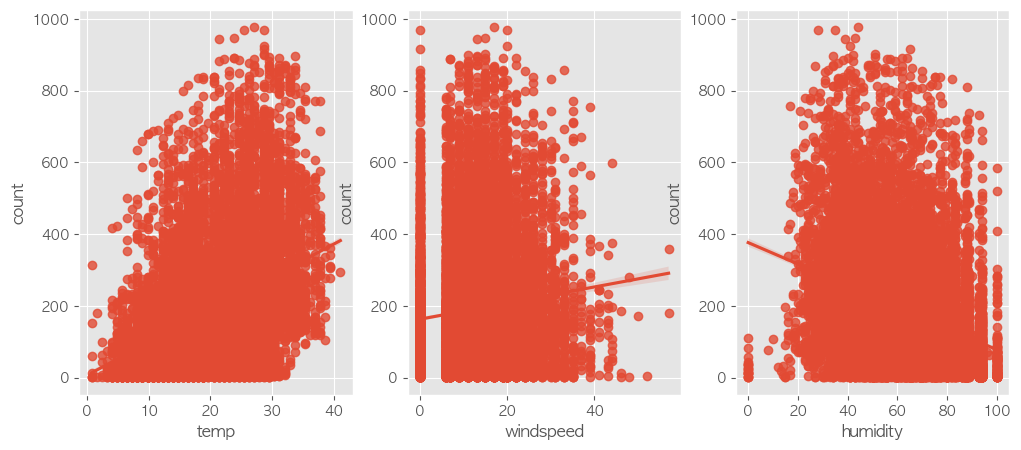

In [33]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train,ax=ax2)
sns.regplot(x="humidity", y="count", data=train,ax=ax3)

# 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

In [47]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<AxesSubplot: xlabel='month', ylabel='count'>

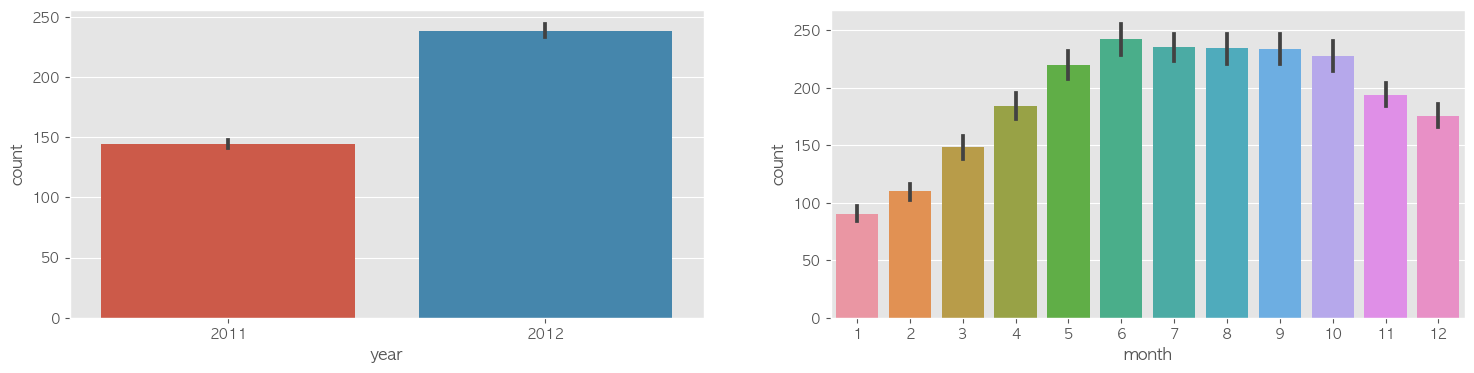

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)



* 2011년보다 2012년의 대여량이 더 많다.
* 겨울보다는 여름에 대여량이 많다.
* 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.

In [52]:
# trainWithoutOutliers (이상치 값 제거하기)

# 0에 몰려있는 데이터와 너무 끝에 있는 데이터를 제거
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 18)
(10739, 18)


/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17826/2653768610.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["count"], ax=axes[0][0])
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17826/2653768610.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(tr

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229774, 4.562423868087808, 0.9581176780909619))

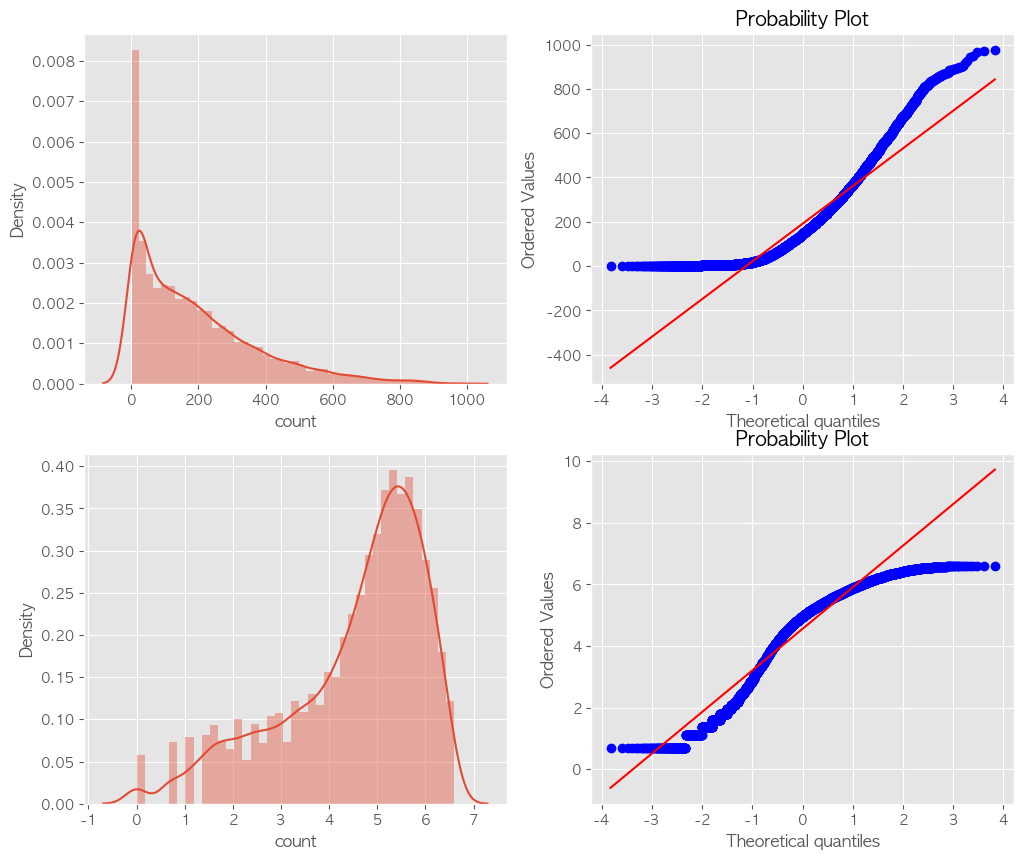

In [53]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

# 이상치 제거 전 정규성 검정
sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
# 이상치 제거 후 정규성 검정
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])